In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
from random import randint
import random
import numpy as np
from matplotlib import pyplot


In [ ]:
# from os import listdir
# from numpy import asarray
# from numpy import vstack
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import load_img
# from numpy import savez_compressed

# # load all images in a directory into memory
# def load_images(path, size=(256,256)):
# 	data_list = list()
# 	# enumerate filenames in directory, assume all are images
# 	for filename in listdir(path):
# 		# load and resize the image
# 		pixels = load_img(path + filename, target_size=size)
# 		# convert to numpy array
# 		pixels = img_to_array(pixels)
# 		# store
# 		data_list.append(pixels)
# 	return asarray(data_list)

# # dataset path
# path = '/content/drive/MyDrive/CycleGAN/rgb2thermal'
# # load dataset A
# dataA1 = load_images(path + '/trainA/')
# dataAB = load_images(path + '/testA/')
# dataA = vstack((dataA1, dataAB))
# print('Loaded dataA: ', dataA.shape)
# # load dataset B
# dataB1 = load_images(path + '/trainB/')
# dataB2 = load_images(path + '/testB/')
# dataB = vstack((dataB1, dataB2))
# print('Loaded dataB: ', dataB.shape)
# # save as compressed numpy array
# filename = 'rgb2thermal.npz'
# savez_compressed(filename, dataA, dataB)
# print('Saved dataset: ', filename)


In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
def load_images(path,size=(256,256)):
    data_list = list()
    name_list = list()
    for filename in sorted(listdir(path)):
        pixels=load_img(path + filename, target_size=size)
        pixels= img_to_array(pixels)
        data_list.append(pixels)
        name_list.append(filename)
    return asarray(data_list),name_list
path = '/content/drive/MyDrive/CycleGAN/final'
dataA1, namesA1= load_images(path + '/trainA/')
dataAB, namesAB= load_images(path + '/testA/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
dataB1, namesB1 = load_images(path + '/trainB/')
dataB2, namesB2 = load_images(path + '/testB/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# filename= '/content/drive/MyDrive/CycleGAN/rgb2thermal.npz'
# savez_compressed(filename, dataA, dataB)
# print('Saved dataset: ', filename)

Loaded dataA:  (198, 256, 256, 3)
Loaded dataB:  (198, 256, 256, 3)


In [ ]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-dbaesbp3
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-dbaesbp3
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101078 sha256=e1fde32bdb33c17b084942435b12314f55577d2b96736553a22423259aa80be1
  Stored in directory: /tmp/pip-ephem-wheel-cache-3fo5udr7/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# define layer
layer = InstanceNormalization(axis=-1)

In [ ]:
# example of defining composite models for training cyclegan generators
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model



# define a composite model for updating generators by adversarial and cycle loss
# def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
# 	# ensure the model we're updating is trainable
# 	g_model_1.trainable = True
# 	# mark discriminator as not trainable
# 	d_model.trainable = False
# 	# mark other generator model as not trainable
# 	g_model_2.trainable = False
# 	# discriminator element
# 	input_gen = Input(shape=image_shape)
# 	gen1_out = g_model_1(input_gen)
# 	output_d = d_model(gen1_out)
# 	# identity element
# 	input_id = Input(shape=image_shape)
# 	output_id = g_model_1(input_id)
# 	# forward cycle
# 	output_f = g_model_2(gen1_out)
# 	# backward cycle
# 	gen2_out = g_model_2(input_id)
# 	output_b = g_model_1(gen2_out)
# 	# define model graph
# 	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
# 	# define optimization algorithm configuration
# 	opt = Adam(lr=0.0002, beta_1=0.5)
# 	# compile model with weighting of least squares loss and L1 loss
# 	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
# 	return model




In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
#efine a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# input shape
image_shape = (256,256,3)
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# g_model_AtoB.summary()

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 798kB 28.0MB/s 


In [ ]:
import visualkeras

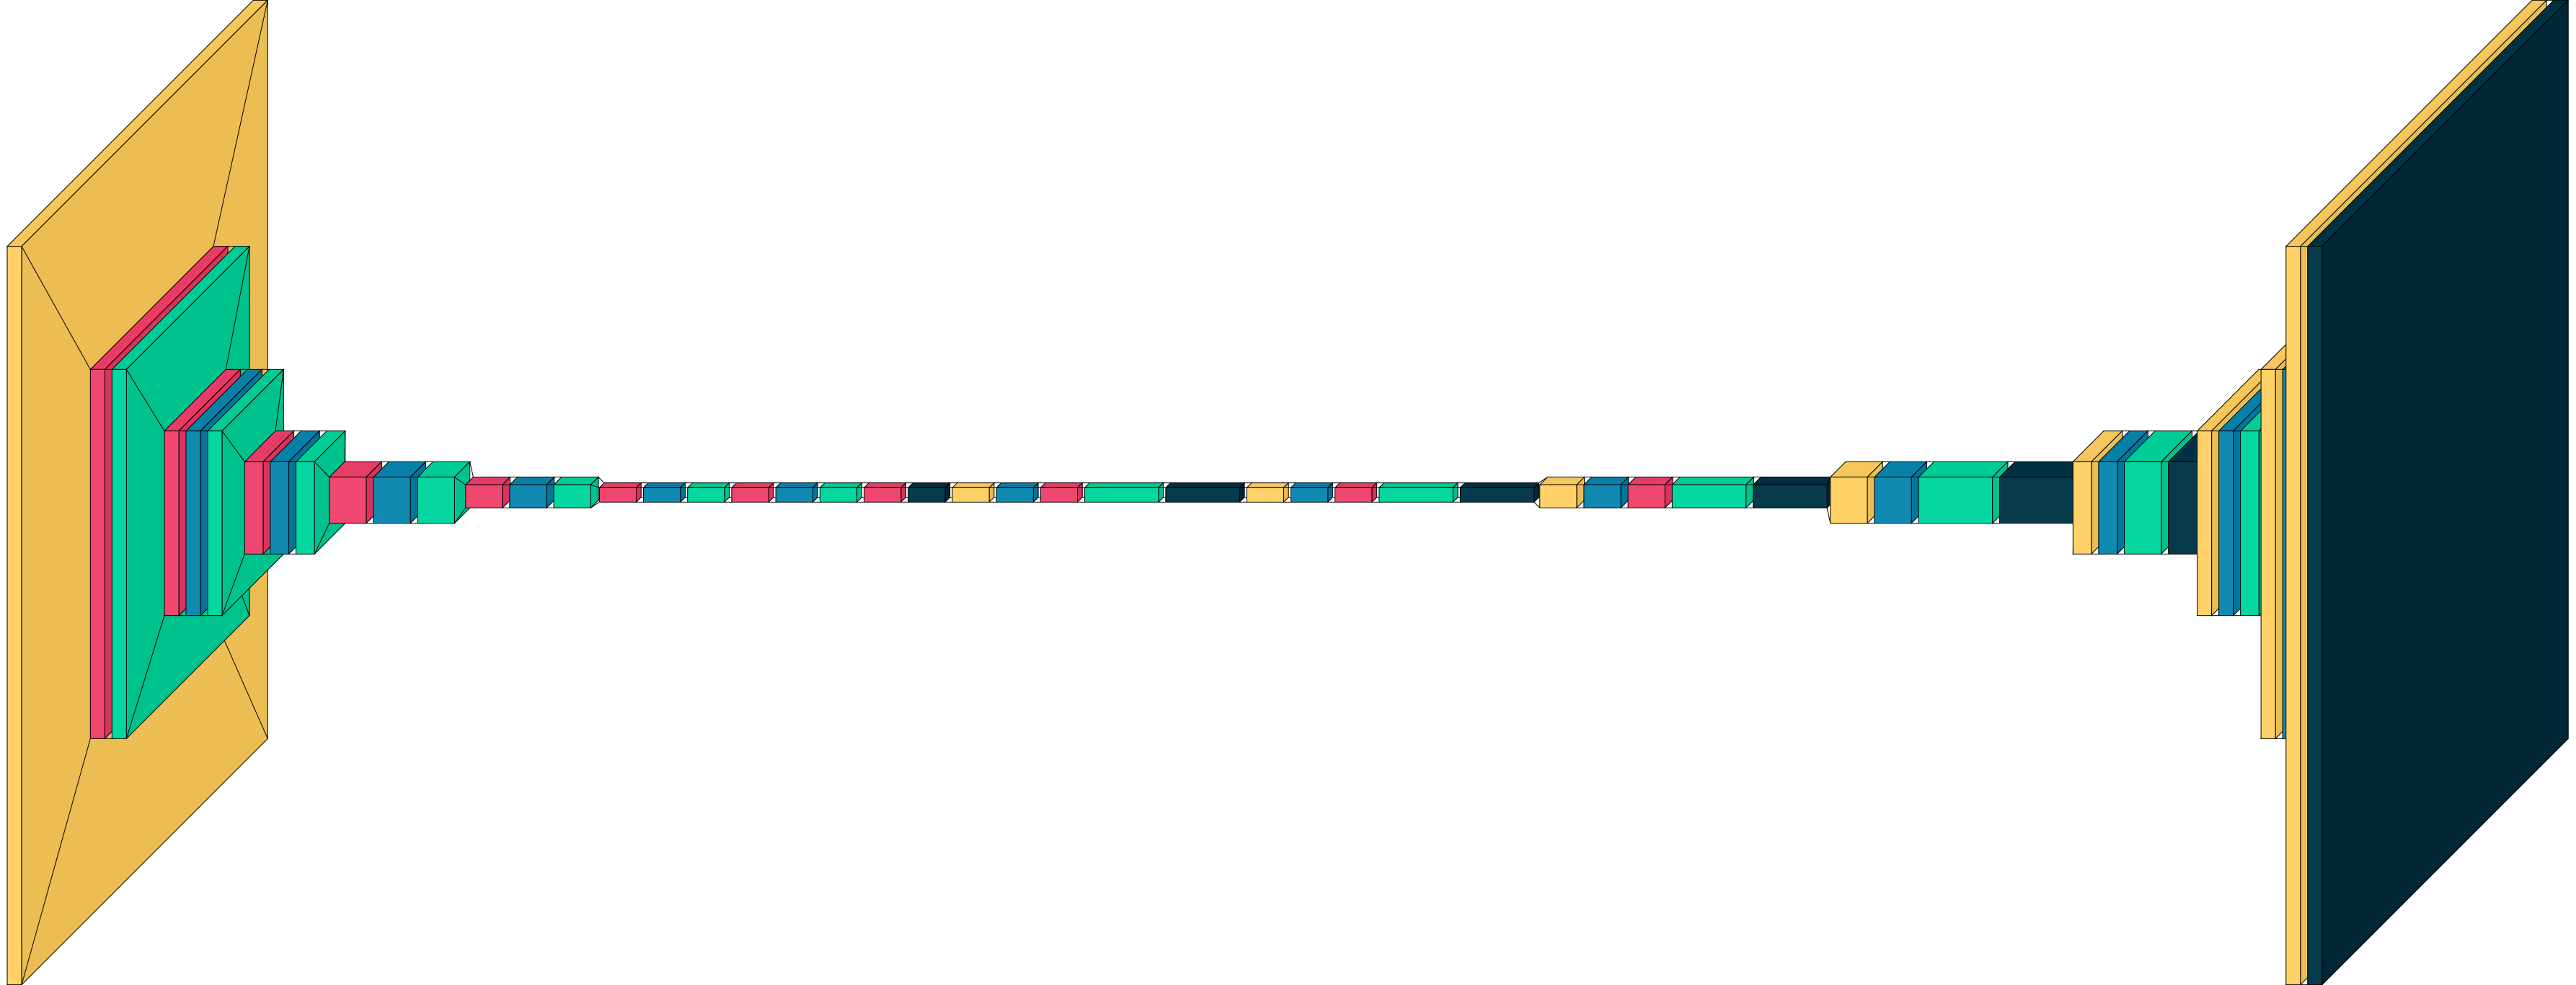

In [ ]:
visualkeras.layered_view(g_model_AtoB)

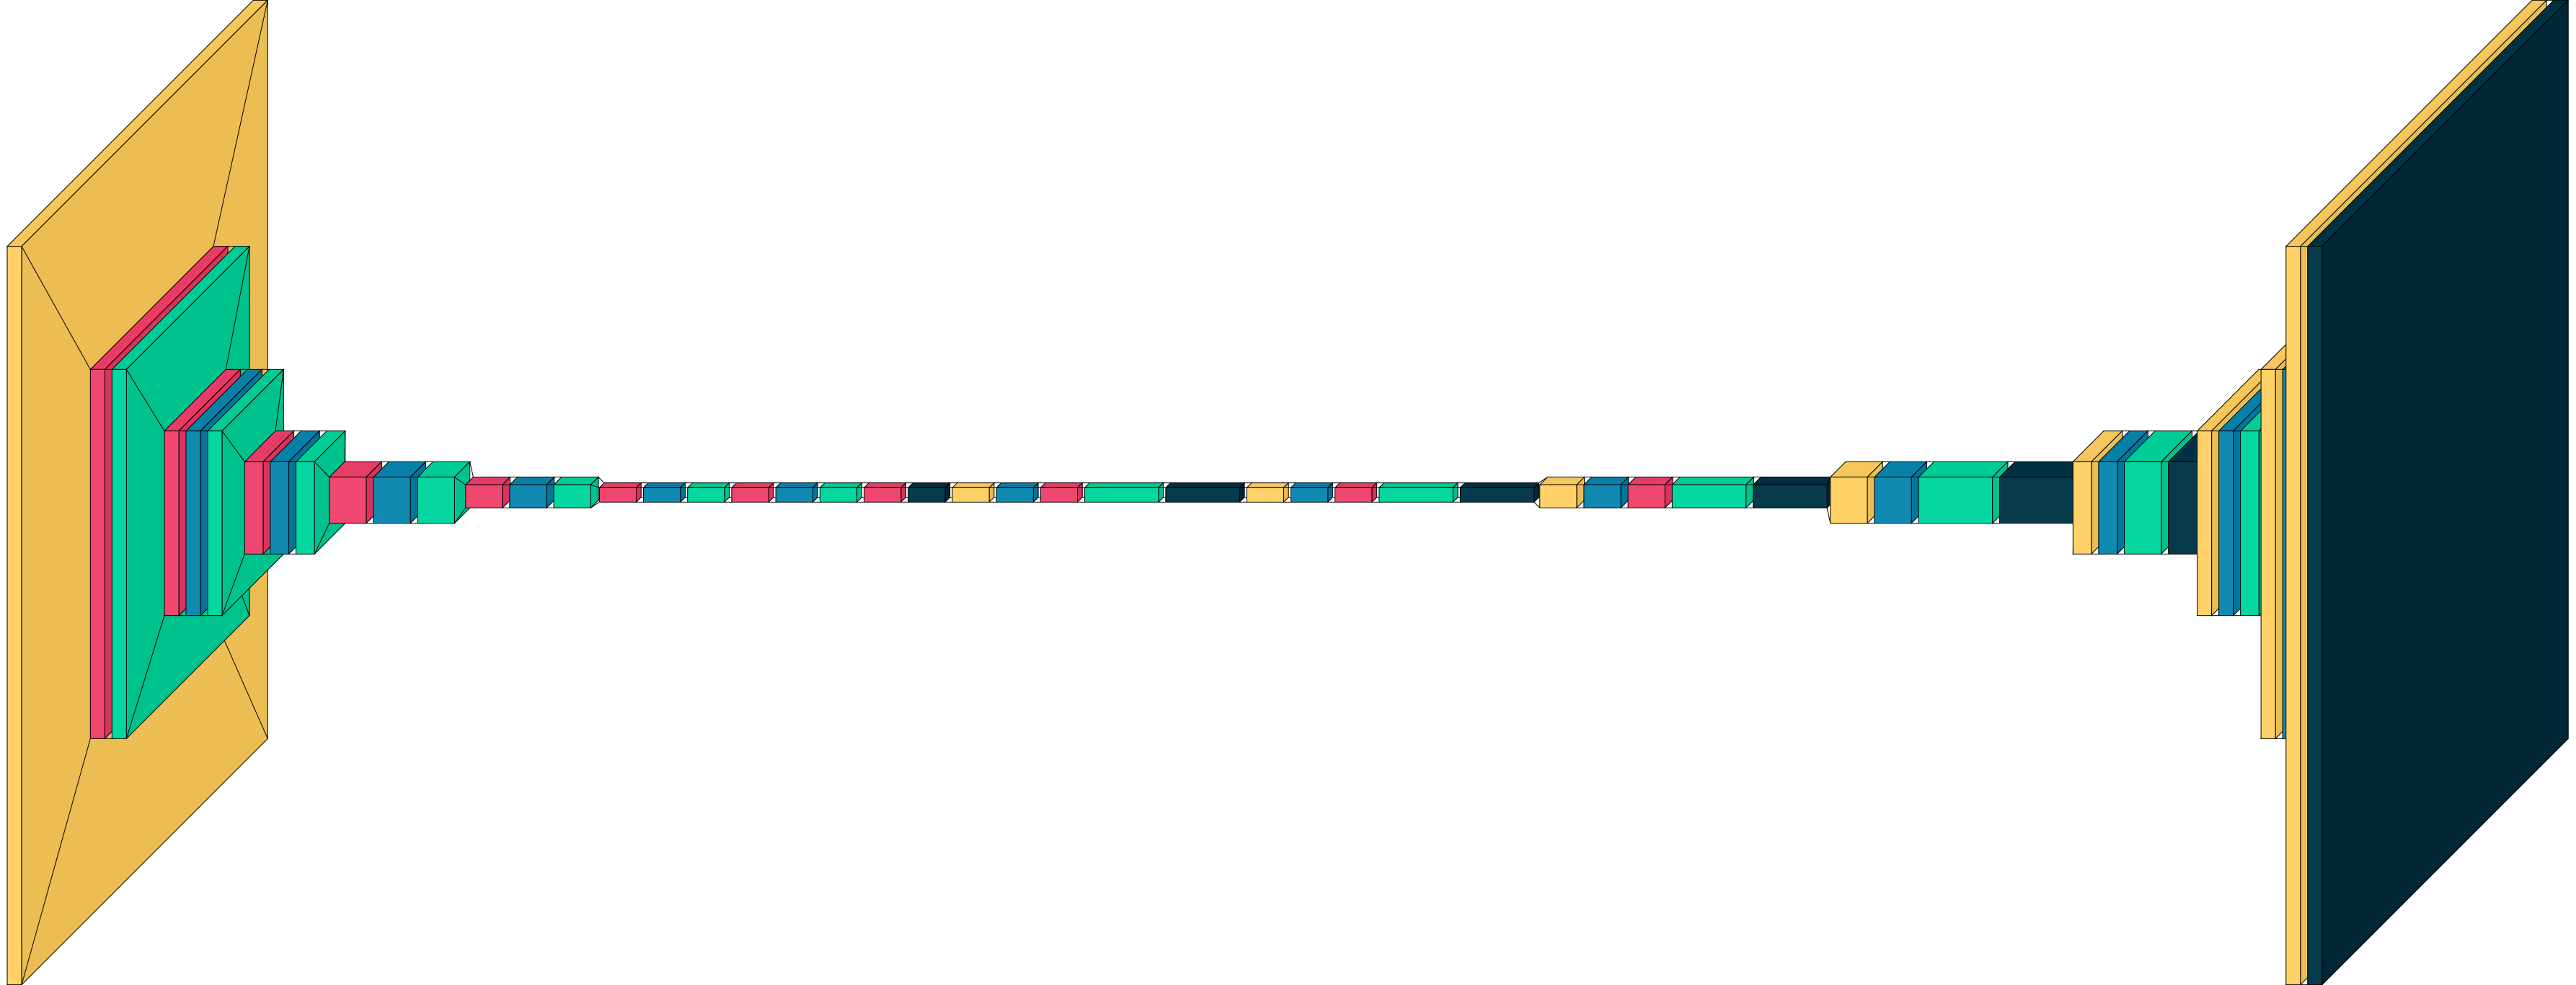

In [ ]:
visualkeras.layered_view(g_model_BtoA)

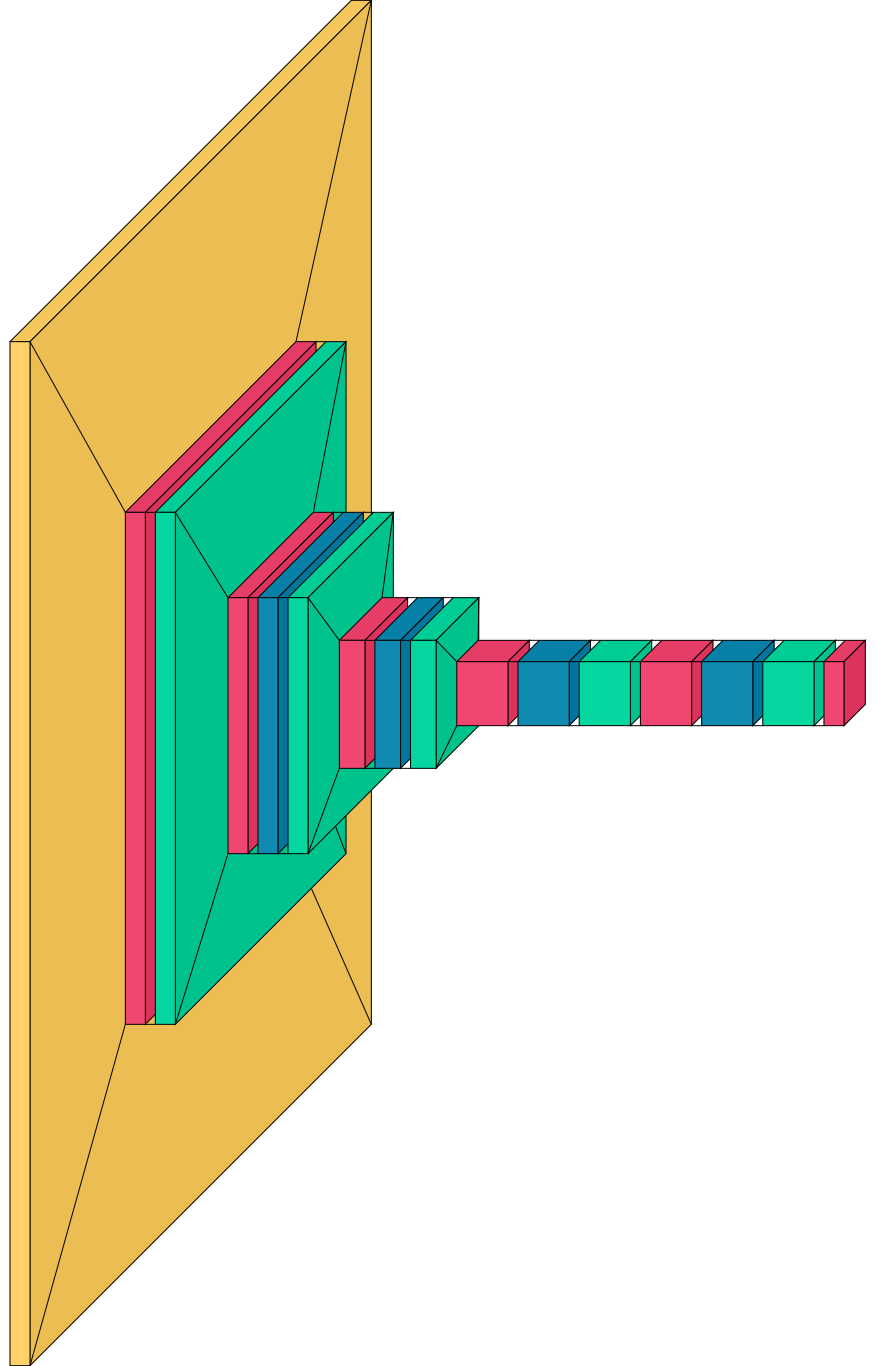

In [ ]:
visualkeras.layered_view(d_model_A)

In [ ]:
g_model_BtoA.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 64) 3136        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_7[0][0]              
____________________________________________________________________________________________

In [ ]:
d_model_A.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 256)       5245

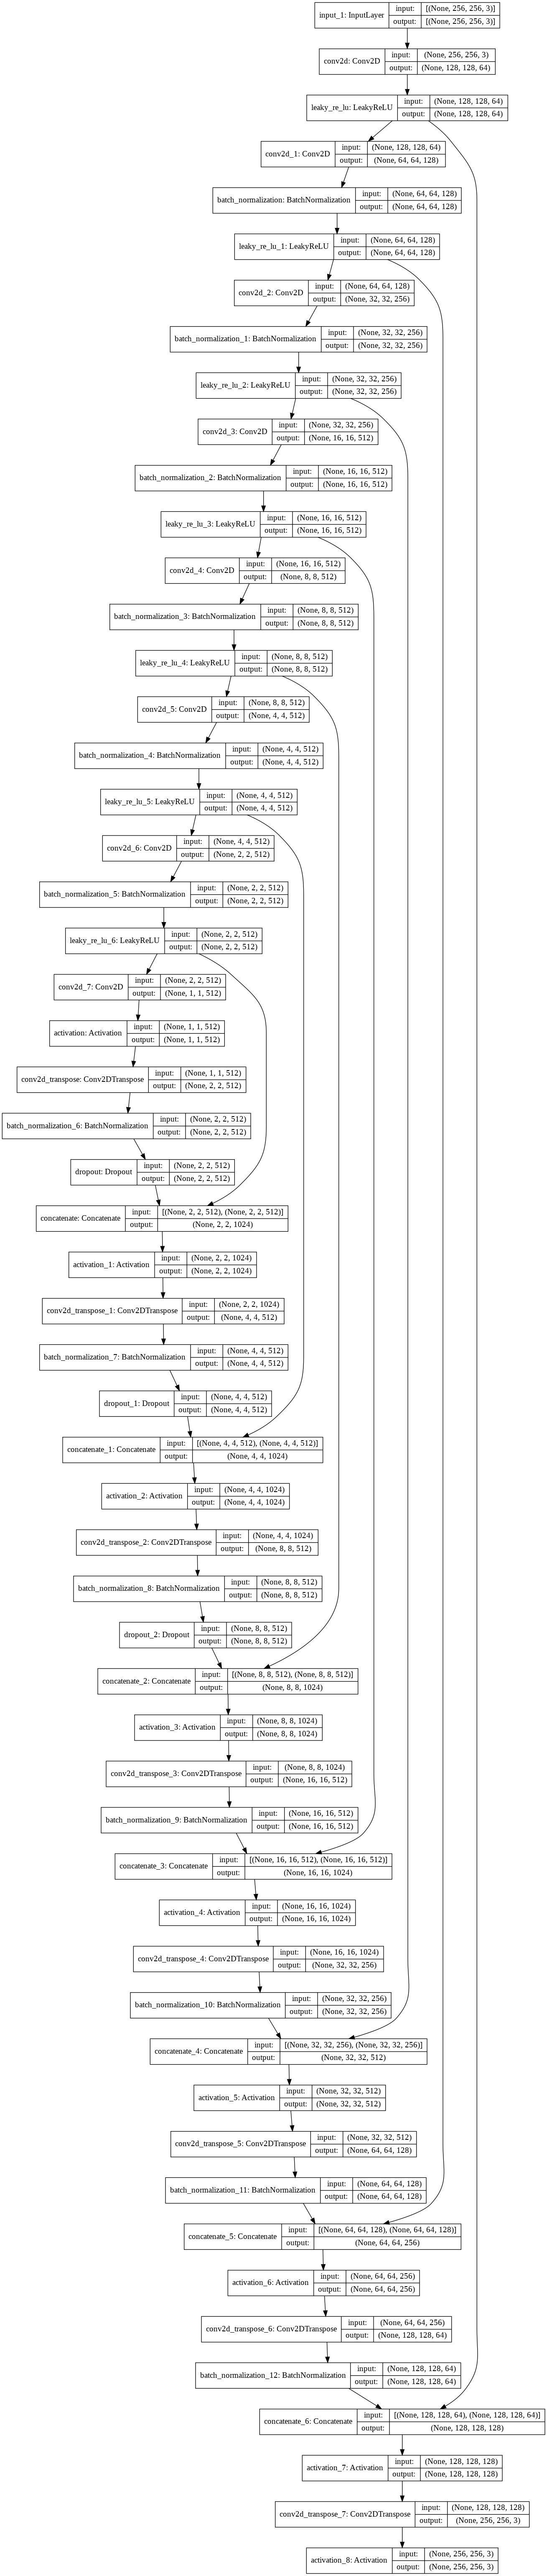

In [ ]:
plot_model(g_model_AtoB, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

This composite model can be called during training ,
1. composite: A -> B -> [real/fake, A]
2. composite: B -> A -> [real/fake, B]

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape, names):
    ix = randint(0, dataset.shape[0]-1)
    X = dataset[ix]
    filename = names[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y, filename

In [ ]:
# def generate_real_samples(dataset, n_samples, patch_shape):
#     ix = randint(0, dataset.shape[0], n_samples)

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:

# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random.random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool)-1)
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
def save_models(step,g_model_AtoB, g_model_BtoA, d_model_A, d_model_B):
    # 1st generator
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save('/content/drive/MyDrive/CycleGAN/checkpoints/'+filename1)
    # 1st discriminator
    filename3= 'd_model_A_%06d.h5' % (step+1)
    d_model_A.save('/content/drive/MyDrive/CycleGAN/checkpoints/'+filename3)
    # tf.keras.experimental.export_saved_model(d_model_A, filename3)
    # 2nd discriminator
    filename4 = 'd_model_B_%06d.h5' % (step+1)
    d_model_B.save('/content/drive/MyDrive/CycleGAN/checkpoints/'+filename4)
    # tf.keras.experimental.export_saved_model(d_model_B, filename4)
    # 2nd generator
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save('/content/drive/MyDrive/CycleGAN/checkpoints/'+filename2)
    print('>Saved: %s and %s and % s and % s' % (filename1, filename2 ,filename3, filename4))

In [ ]:
def summarize_performance(step, g_model, trainX, name, names, n_samples=1):
    # print("in summarize performance")
    # print("trainX.shape = ",trainX.shape)
    X_in, _, _ = generate_real_samples(trainX, n_samples, 0, names)
    X_in = np.reshape(X_in,(1,256,256,3))
    # print("real samples generated, X_in.shape = ",X_in.shape)
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # print("fake samples generated")
    # X_in = float(float(X_in)/255.0)
    # X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    print(X_out)
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i].astype('uint8'))
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    filename1 = '/content/drive/MyDrive/CycleGAN/fake_images/%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()


In [ ]:

def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA,trainB, namesA, namesB):
    n_epochs, n_batch, = 100, 1
    n_patch = d_model_A.output_shape[1]
    poolA, poolB = list(), list()
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_realA, y_realA, filenameA = generate_real_samples(trainA, n_batch, n_patch, namesA)
        X_realB, y_realB, filenameB = generate_real_samples(trainB, n_batch, n_patch, namesB)
        # print("XRealB shape:",X_realB.shape)
        # print("filenameA = ", filenameA)
        # print("filenameB = ", filenameB)
        X_realB = np.reshape(X_realB,(1,256,256,3))
        X_realA = np.reshape(X_realA,(1,256,256,3))
        # print("XRealB shape:",X_realB.shape)
        # print("XRealA.shape:", X_realA.shape)
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # print("fakes made")
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # print("XFakeB.shape:", X_fakeB.shape)
        # print("XFakeA.shape",X_fakeA.shape)
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # print("genrator BtoA passed")
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)

        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # print("discriminator A passed")
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # print("generator AtoB passed")
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        # print("discriminator B passed")

        # if i%50 == 0:
        #     # print("X_fakeB")
        #     # print(X_fakeB[0])
        #     # print("X_realA")
        #     # print(X_realA[0])
        #     f, axarr = plt.subplots(1,2)
        #     axarr[0] = plt.imshow(X_fakeB[0].astype('uint8'))
        #     axarr[1] = plt.imshow(X_realA[0].astype('uint8'))
        #     plt.show()

        # if (i+1) % (bat_per_epo * 5) == 0:
        #     save_models(i, g_model_AtoB, g_model_BtoA)

        if (i+1) % (bat_per_epo * 1) == 0:
            # print("inside if")
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB', namesA)
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA', namesB)
            # print("after summarize")

        if (i+1) % (bat_per_epo * 1) == 0:
            print("going to save")
            save_models(i, g_model_AtoB, g_model_BtoA, d_model_A, d_model_B)

        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))




In [ ]:
# load a dataset as a list of two numpy arrays
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataA1,dataB1,namesA1,namesB1)

>1, dA[0.758,1.326] dB[1.067,0.588] g[3400.950,3300.830]
>2, dA[3.065,10.762] dB[15.711,1.007] g[4513.020,4996.478]
>3, dA[5.000,5.790] dB[9.256,0.750] g[3335.158,3246.012]
>4, dA[1.432,2.412] dB[4.084,0.898] g[3367.501,2945.038]
>5, dA[1.129,1.912] dB[3.883,0.784] g[3539.338,3162.267]
>6, dA[0.660,2.010] dB[2.817,0.822] g[4022.156,4395.950]
>7, dA[1.677,2.980] dB[1.728,0.986] g[3032.502,2837.117]
>8, dA[2.520,1.673] dB[0.893,0.513] g[4068.791,4215.460]
>9, dA[1.856,1.273] dB[0.445,0.595] g[3344.644,3308.621]
>10, dA[1.086,1.138] dB[0.135,0.588] g[3271.222,2905.112]
>11, dA[1.027,1.593] dB[0.090,0.786] g[3036.140,2780.913]
>12, dA[0.884,1.499] dB[0.184,0.754] g[3282.124,3291.622]
>13, dA[0.872,1.137] dB[0.069,0.590] g[3784.196,3331.605]
>14, dA[0.706,1.402] dB[0.088,0.424] g[3192.739,2758.221]
>15, dA[0.479,1.172] dB[0.062,0.529] g[3914.565,4028.704]
>16, dA[0.501,0.738] dB[0.083,0.531] g[3124.198,2886.129]
>17, dA[0.377,0.795] dB[0.091,0.298] g[3599.449,3411.051]
>18, dA[0.302,0.749] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.9763816   1.          1.        ]
  [ 1.          0.93004936  1.        ]
  [ 0.89614505  1.          1.        ]
  ...
  [ 1.          0.0093096   1.        ]
  [ 0.9981091   1.          1.        ]
  [ 1.          0.513861    1.        ]]

 [[ 0.334439    1.          1.        ]
  [ 1.          1.          1.        ]
  [ 0.8985018   1.          1.        ]
  ...
  [ 1.          1.          1.        ]
  [ 0.9777997   1.          1.        ]
  [ 1.          1.          1.        ]]

 [[-0.0695764   1.          1.        ]
  [ 1.          0.99866515  1.        ]
  [ 0.88639504  1.          1.        ]
  ...
  [ 1.          0.9376755   1.        ]
  [ 0.9999754   1.          1.        ]
  [ 1.         -0.5811677   1.        ]]

 ...

 [[ 0.4731825   1.          0.9999962 ]
  [ 1.          1.          1.        ]
  [-0.15182799  1.          1.        ]
  ...
  [ 1.          1.          1.        ]
  [-0.18698582  1.          1.        ]
  [ 1.          1.          1.        ]]

 [

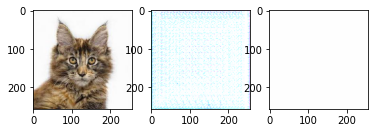

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.99407655  0.70599365  0.92083746]
  [ 0.9999468   0.936642    0.9951322 ]
  [ 0.9973481   0.94486433  0.7880219 ]
  ...
  [ 0.99994606  0.9997196   0.998556  ]
  [ 0.999027    0.9994084   0.91604966]
  [ 0.99996805  0.99425066  0.5318336 ]]

 [[ 0.6727763  -0.47561914  0.05126947]
  [ 0.9850074   0.52430207  0.32881954]
  [ 0.99609685  0.19187091 -0.1975635 ]
  ...
  [ 0.87504405  0.4977099   0.99996775]
  [-0.88647664  0.99978983 -0.8679539 ]
  [ 0.8020843   0.99264246  0.99987334]]

 [[ 0.9946552   0.994644    0.9875931 ]
  [ 0.8798431   0.95888245  0.99367386]
  [ 0.98953736  0.8636045   0.11857153]
  ...
  [ 0.36088702  0.816469    0.9949497 ]
  [ 0.8648511   0.47837052 -0.9418345 ]
  [ 0.99999934 -0.98630416  0.42657116]]

 ...

 [[ 0.9593216   0.968488    0.8244029 ]
  [ 0.99394685  0.59271777  0.54791063]
  [ 0.99993247  0.9914616   0.15212119]
  ...
  [-0.33969223  0.26624012  0.11050306]
  [ 0.5809678   0.99993247 -0.6679902 ]
  [ 0.07331254  0.9956487   0.98785347]]

 [

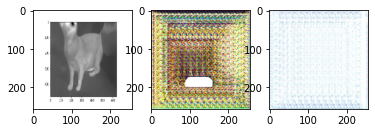

In [ ]:

# # example of using saved cyclegan models for image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import cv2

# # load and prepare training images
# def load_real_samples(filename):
# 	# load the dataset
# 	data = load(filename)
# 	# unpack arrays
# 	X1, X2 = data['arr_0'], data['arr_1']
# 	# scale from [0,255] to [-1,1]
# 	X1 = (X1 - 127.5) / 127.5
# 	X2 = (X2 - 127.5) / 127.5
# 	return [X1, X2]

# # select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
    # imagesY1 = (imagesY1 + 1) / 2.0
    imagesY2 = (imagesY2 + 1) / 2.0
    # print("imagesX.shape",imagesX.shape)
    # print("imagesY1.shape", imagesY1.shape)
    # print("imagesY2.shape",imagesY2.shape)
    print(imagesY1)
    f, axarr = pyplot.subplots(1,3)
    axarr[0].imshow(imagesX.astype('uint8'))
    axarr[1].imshow(imagesY1)
    axarr[2].imshow(imagesY2)
    pyplot.show()
# def show_plot(imagesX, imagesY1, imagesY2):
#     images= vstack((imagesX, imagesY1, imagesY2))
#     titles = ['Real', 'Generated', 'Reconstructed']
#     # scale from [-1,1] to [0,1]
#     images = (images + 1) / 2.0
#     # plot images row by row
#     for i in range(len(images)):
#         pyplot.subplot(1, len(images), 1 + i)
#         pyplot.axis('off')
#         # plot raw pixel data
#         # print(i)
#         pyplot.imshow(images[i])
#         pyplot.title(titles[i])
#     pyplot.show()




# # load dataset
# A_data, B_data = load_real_samples('horse2zebra_256.npz')
# print('Loaded', A_data.shape, B_data.shape)
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/MyDrive/CycleGAN/checkpoints/g_model_AtoB_001790.h5', cust)
model_BtoA = load_model('/content/drive/MyDrive/CycleGAN/checkpoints/g_model_BtoA_001790.h5', cust)
# plot A->B->A
for i in range(1):
# for i in range(dataAB.shape[0]):
    A_real = np.reshape(dataAB[i],(1,256,256,3))
    # np.reshape(A_real,(256,256,3))
    B_generated  = model_AtoB.predict(A_real)
    # np.reshape(B_generated,(256,256,3))
    A_reconstructed = model_BtoA.predict(B_generated)
    # np.reshape(A_reconstructed,(256,256,3))
    A_real = np.reshape(A_real,(256,256,3))
    B_generated = np.reshape(B_generated,(256,256,3))
    A_reconstructed = np.reshape(A_reconstructed,(256,256,3))
    show_plot(A_real, B_generated, A_reconstructed)
    # plot B->A->B
    B_real = np.reshape(dataB2[i],(1,256,256,3))
    # np.reshape(B_real,(256,256,3))
    A_generated  = model_BtoA.predict(B_real)
    # np.reshape(A_generated,(256,256,3))
    B_reconstructed = model_AtoB.predict(A_generated)
    B_real = np.reshape(B_real,(256,256,3))
    A_generated = np.reshape(A_generated,(256,256,3))
    B_reconstructed = np.reshape(B_reconstructed,(256,256,3 ))
    show_plot(B_real, A_generated, B_reconstructed)

In [ ]:
from keras.models import load_model
# import tensorflow as tf
new_g_model_AtoB = load_model('/content/drive/MyDrive/CycleGAN/checkpoints/g_model_AtoB_001790.h5')
new_g_model_BtoA=load_model('/content/drive/MyDrive/CycleGAN/checkpoints/g_model_BtoA_001790.h5')
# new_d_model_A= load_model('/content/drive/MyDrive/CycleGAN/checkpoints/d_model_A_003050.h5')
# new_d_model_A = tf.keras.models.load_model('/content/drive/MyDrive/CycleGAN/checkpoints/d_model_A_001830.h5 ')
# new_d_model_B= load_model('/content/drive/MyDrive/CycleGAN/checkpoints/d_model_B_003050.h5')
new_c_model_AtoB = define_composite_model(new_g_model_AtoB, d_model_B, new_g_model_BtoA, image_shape)
new_c_model_BtoA = define_composite_model(new_g_model_BtoA, d_model_A, new_g_model_AtoB, image_shape)



In [ ]:
train(d_model_A, d_model_B, new_g_model_AtoB, new_g_model_BtoA, new_c_model_AtoB, new_c_model_BtoA, dataA1,dataB1,namesA1,namesB1)

>1, dA[1.351,1.081] dB[0.922,1.242] g[2734.572,2342.032]
>2, dA[1.025,9.928] dB[13.419,6.670] g[3173.712,2958.882]
>3, dA[2.587,5.312] dB[5.113,1.304] g[4534.197,4734.741]
>4, dA[2.849,2.962] dB[4.951,1.101] g[3354.374,3060.706]
>5, dA[3.006,5.502] dB[5.859,0.675] g[3374.845,3169.356]
>6, dA[1.637,5.500] dB[2.832,0.359] g[3553.430,3488.193]
>7, dA[1.052,3.307] dB[1.011,0.482] g[4147.516,3876.659]
>8, dA[1.314,1.676] dB[0.493,0.925] g[4283.586,4409.735]
>9, dA[0.780,2.027] dB[0.471,0.879] g[3073.995,2879.251]
>10, dA[0.922,2.951] dB[0.336,1.107] g[3425.398,3044.271]
>11, dA[0.715,2.500] dB[0.144,2.330] g[3366.759,3359.563]
>12, dA[0.672,1.631] dB[0.118,1.504] g[4138.976,4036.501]
>13, dA[0.728,0.671] dB[0.101,1.093] g[3072.781,2907.407]
>14, dA[0.592,0.442] dB[0.242,0.526] g[4149.670,3709.068]
>15, dA[0.490,0.638] dB[0.181,0.550] g[3878.541,3797.414]
>16, dA[0.519,0.683] dB[0.101,0.521] g[3608.183,3546.663]
>17, dA[0.460,0.789] dB[0.110,0.410] g[3139.698,2799.831]
>18, dA[0.561,0.730] d

In [ ]:
imageA=
imageB=

In [ ]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])

	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err